In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline
import os
from scipy.stats import gaussian_kde
import metpy.calc as mpcalc
from metpy.units import units

In [2]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  file_dir = "F:/github/pythonScript/seafog/"
else:
  file_dir = "H:/github/python/seafog/"

def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

def reverse_linear_vis(x):
    if(x<0):
      y = 1
    elif(x <= 1.0):
      y = x*1000.0
    elif(x <= 2.0):
      y = (x - 1.0)*9000.0 + 1000.0
    elif(x <= 3.0):
      y = (x-2.0)*20000 + 10000.0
    else:
      y = 30000.0
    return y

In [3]:
file_59754 = os.path.normpath(os.path.join(file_dir, './data/2023/59754.20230101-20230131.csv')) # 读取徐闻站分钟级数据
df_59754 = pd.read_csv(file_59754,sep=',',na_values=[9999])
df_59754.index = pd.to_datetime(df_59754["DDATETIME"])

df_code = pd.read_csv(os.path.normpath(os.path.join(file_dir, './code_readme.csv')),sep=',')

C:\Users\henry_Hill\AppData\Local\Temp\ipykernel_12272\3360652241.py:2: DtypeWarning: Columns (112) have mixed types. Specify dtype option on import or set low_memory=False.
  df_59754 = pd.read_csv(file_59754,sep=',',na_values=[9999])


In [4]:
bjtime_index_59754 = df_59754.index.to_series() + pd.Timedelta(8,unit='h')
df_59754['ObserveTime'] = bjtime_index_59754.values

In [33]:
code_info = {
  'vis01':'V20059',
  'vis_01min':'V20001_701_01',
  'vis_10min':'V20001_701_10',
  'vis':'V20001',
  'td': 'V12003',
  't2m': 'V12001',
  "year":"V04001",
  "month": "V04002",
  "day": "V04003",
  "hour":"V04004",
  "minute":"V04005",
  "rhum":"V13003",
  'rain01':'V13019',
  'windspeed02':'V11291',
  'windDir02':'V11290',
  'cloud':'V20011',
}

In [6]:
df_G7425 = pd.read_csv(os.path.normpath(os.path.join(file_dir, './data/2023/G7425-202301.txt')),sep=',',na_values=[9999.0, -9999.0],dtype={"ObserveTime":str})
df_G7425['date'] = pd.to_datetime(df_G7425['ObserveTime'])
df_G7425.index = df_G7425['date']
df_G7425['ObserveTime'] = df_G7425['date']


In [7]:
rhum = df_G7425['RelativeHumidity'].values*units.percent
temp = df_G7425['Temperature'].values*units.degC
td = mpcalc.dewpoint_from_relative_humidity(temp, rhum)
df_G7425['Dewpoint'] = td
df_G7425['t-td'] = df_G7425['Temperature'] - df_G7425['Dewpoint']
df_G7425['td-sst'] = df_G7425['Dewpoint'] - df_G7425['SeaTemperature']
df_G7425['t-sst'] = df_G7425['Temperature'] - df_G7425['SeaTemperature']


In [8]:
df_59754['uwnd'] = -df_59754[code_info['windspeed02']]*np.cos((90-df_59754[code_info['windDir02']])/180*np.pi)
df_59754['vwnd'] = -df_59754[code_info['windspeed02']]*np.sin((90-df_59754[code_info['windDir02']])/180*np.pi)

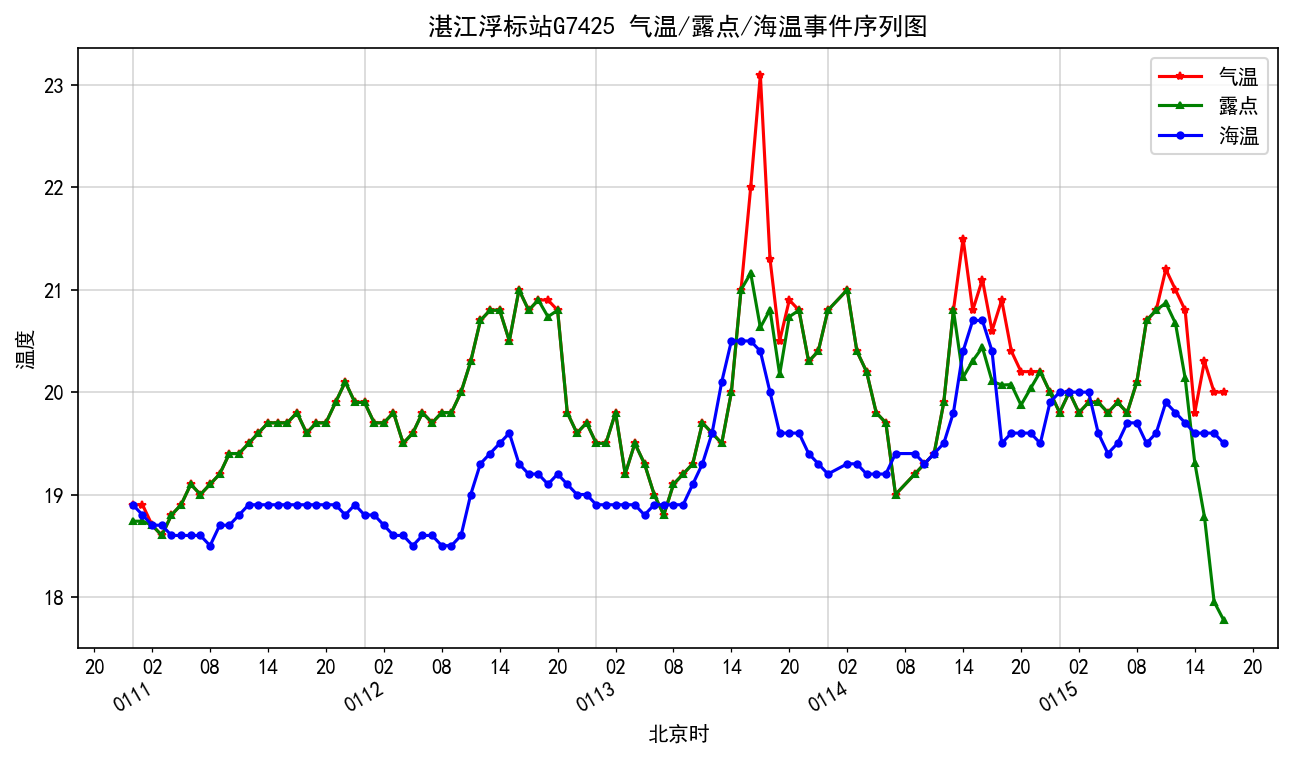

In [9]:
time_mask = ((df_G7425['ObserveTime'] >= pd.Timestamp('2023-01-11 00:00')) & (df_G7425['ObserveTime'] <= pd.Timestamp('2023-01-15 17:00')))
df_G7425_mask = df_G7425.loc[time_mask]
fig = plt.figure(figsize=(8, 4), dpi=150)  # 添加画布
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylabel("海雾")
line_t2m, = ax.plot(df_G7425_mask.index, df_G7425_mask['Temperature'], color='r', marker='*', markersize=4, label='2m气温', zorder=2)
line_td, = ax.plot(df_G7425_mask.index, df_G7425_mask['Dewpoint'], color='g', marker='^', markersize=3, label='露点', zorder=3)
line_sst, = ax.plot(df_G7425_mask.index, df_G7425_mask['SeaTemperature'], color='b', marker='o', markersize=3, label='海温', zorder=4)

# 设置x轴主刻度格式
alldays = mdates.DayLocator()  # 主刻度为每天
ax.xaxis.set_major_locator(alldays)  # 设置主刻度
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m%d'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
# 设置副刻度格式
hoursLoc = mpl.dates.HourLocator(byhour=[2, 8, 14, 20])  # 为6小时为1副刻度
ax.xaxis.set_minor_locator(hoursLoc)
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
# 参数pad用于设置刻度线与标签间的距离
ax.tick_params(axis='x', which='major', pad=15, length=0)
ax.grid(True,alpha=0.5)
ax.set_xlabel("北京时")
ax.set_ylabel("温度")
ax.set_title(f'湛江浮标站G7425 气温/露点/海温事件序列图')
plt.legend([line_t2m, line_td, line_sst], ['气温', '露点', '海温'])

In [10]:
inter_index = df_G7425.index.intersection(bjtime_index_59754)
utc_inter_index = inter_index.to_series() + pd.Timedelta(-8,unit='h')

df_G7425_inter = df_G7425.loc[inter_index]
df_59754_inter = df_59754.loc[utc_inter_index]

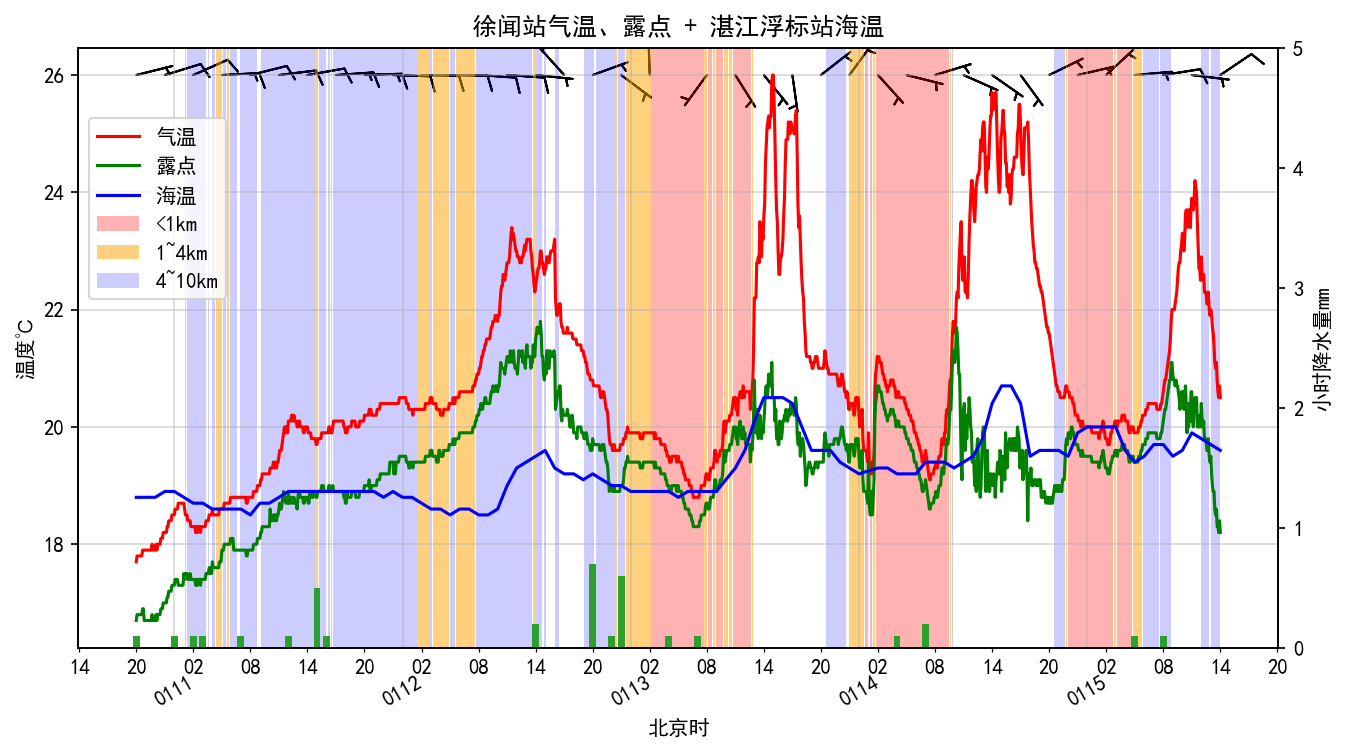

In [41]:
start_time = pd.Timestamp('2023-01-10 20:00')
end_time = pd.Timestamp('2023-01-15 14:00')
time_mask = ((df_59754['ObserveTime'] >= start_time) & (df_59754['ObserveTime'] <= end_time))
df_59754_mask = df_59754.loc[time_mask]
df_G7425_mask = df_G7425.loc[((df_G7425['ObserveTime'] >= start_time) & (df_G7425['ObserveTime'] <= end_time))]

fig = plt.figure(figsize=(8, 4), dpi=150)  # 添加画布
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylabel("海雾")
line_t2m, = ax.plot(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']], color='r', markersize=4, label='2m气温', zorder=2)
line_td, = ax.plot(df_59754_mask['ObserveTime'], df_59754_mask[code_info['td']], color='g',  label='露点', zorder=3)
line_sst, = ax.plot(df_G7425_mask.index, df_G7425_mask['SeaTemperature'], color='b', label='海温', zorder=4)
_,_x, ymin, ymax = plt.axis()
ax.set_ylim(ymin, ymax)
# bar_rain = ax2.bar(df_59754_mask['ObserveTime'], df_59754_mask[code_info['rain01']], linewidth=0, align='center', width=0.1, color='tab:green', label='降水', zorder=0)

# 绘制降水
ax2 = ax.twinx()
df_59754_time_int = df_59754_mask.loc[df_59754_mask['ObserveTime'].dt.minute==0]
bar_rain = ax2.bar(df_59754_time_int['ObserveTime'], df_59754_time_int[code_info['rain01']], linewidth=0, align='center', width=0.03, color='tab:green', label='降水', zorder=0)
ax2.set_ylim(0, 5)
ax2.set_ylabel("小时降水量mm")
# 绘制风
time_step_barb = 3
ax.barbs(df_59754_time_int['ObserveTime'][::time_step_barb], [26], 
        df_59754_time_int['uwnd'][::time_step_barb],df_59754_time_int['vwnd'][::time_step_barb],barb_increments={'half':2,'full':4,'flag':20},
        length=6,sizes={'emptybarb':0},
        )

# 绘制能见度区域
td_min = df_59754_mask[code_info['td']].min()
vis01 = ax.fill_between(df_59754_mask['ObserveTime'], ymax,ymin, where=df_59754_mask[code_info['vis_10min']] < 1000, facecolor='red', alpha=.3)
vis02 = ax.fill_between(df_59754_mask['ObserveTime'], ymax,ymin, where=((df_59754_mask[code_info['vis_10min']] > 1000) & (df_59754_mask[code_info['vis_10min']]<4000)), facecolor='orange', alpha=.5)
vis03 = ax.fill_between(df_59754_mask['ObserveTime'], ymax,ymin, where=((df_59754_mask[code_info['vis_10min']] > 4000) & (df_59754_mask[code_info['vis_10min']]<10000)), facecolor='blue', alpha=.2)

# 设置x轴主刻度格式
alldays = mdates.DayLocator()  # 主刻度为每天
ax.xaxis.set_major_locator(alldays)  # 设置主刻度
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m%d'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
# 设置副刻度格式
hoursLoc = mpl.dates.HourLocator(byhour=[2, 8, 14, 20])  # 为6小时为1副刻度
ax.xaxis.set_minor_locator(hoursLoc)
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
# 参数pad用于设置刻度线与标签间的距离
ax.tick_params(axis='x', which='major', pad=12, length=0)
ax.grid(True,alpha=0.5)
ax.set_xlabel("北京时")
ax.set_ylabel("温度℃")
ax.set_title(f'徐闻站气温、露点 + 湛江浮标站海温')



plt.legend([line_t2m, line_td, line_sst,vis01,vis02,vis03], ['气温', '露点', '海温','<1km','1~4km','4~10km'],loc='upper left',bbox_to_anchor=(0.0, 0.9))



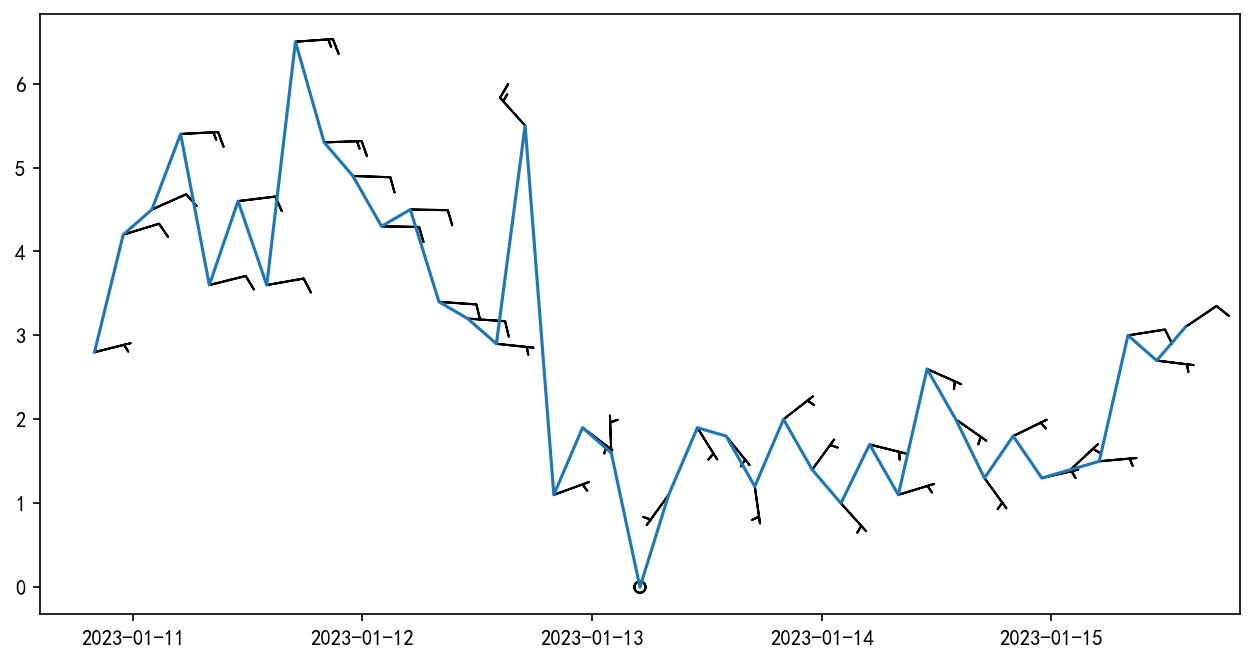

In [24]:
start_time = pd.Timestamp('2023-01-10 20:00')
end_time = pd.Timestamp('2023-01-15 14:00')
time_mask = ((df_59754['ObserveTime'] >= start_time) & (df_59754['ObserveTime'] <= end_time))
df_59754_mask = df_59754.loc[time_mask]
df_G7425_mask = df_G7425.loc[((df_G7425['ObserveTime'] >= start_time) & (df_G7425['ObserveTime'] <= end_time))]

fig = plt.figure(figsize=(8, 4), dpi=150)  # 添加画布
ax = fig.add_axes([0, 0, 1, 1])
df_59754_time_int = df_59754_mask.loc[df_59754_mask['ObserveTime'].dt.minute==0]
ax.barbs(df_59754_time_int['ObserveTime'][::3], df_59754_time_int[code_info['windspeed02']][::3], 
        df_59754_time_int['uwnd'][::3],df_59754_time_int['vwnd'][::3],barb_increments={'half':2,'full':4,'flag':20},
        length=6,
        )
ax.plot(df_59754_time_int['ObserveTime'][::3], df_59754_time_int[code_info['windspeed02']][::3])



In [34]:
df_59754_mask[code_info['cloud']]

DDATETIME
2023-01-10 12:00:00   NaN
2023-01-10 12:05:00   NaN
2023-01-10 12:10:00   NaN
2023-01-10 12:15:00   NaN
2023-01-10 12:20:00   NaN
                       ..
2023-01-15 05:40:00   NaN
2023-01-15 05:45:00   NaN
2023-01-15 05:50:00   NaN
2023-01-15 05:55:00   NaN
2023-01-15 06:00:00   NaN
Name: V20011, Length: 1369, dtype: float64

In [56]:
len( df_G7425_mask['SeaTemperature'])

113

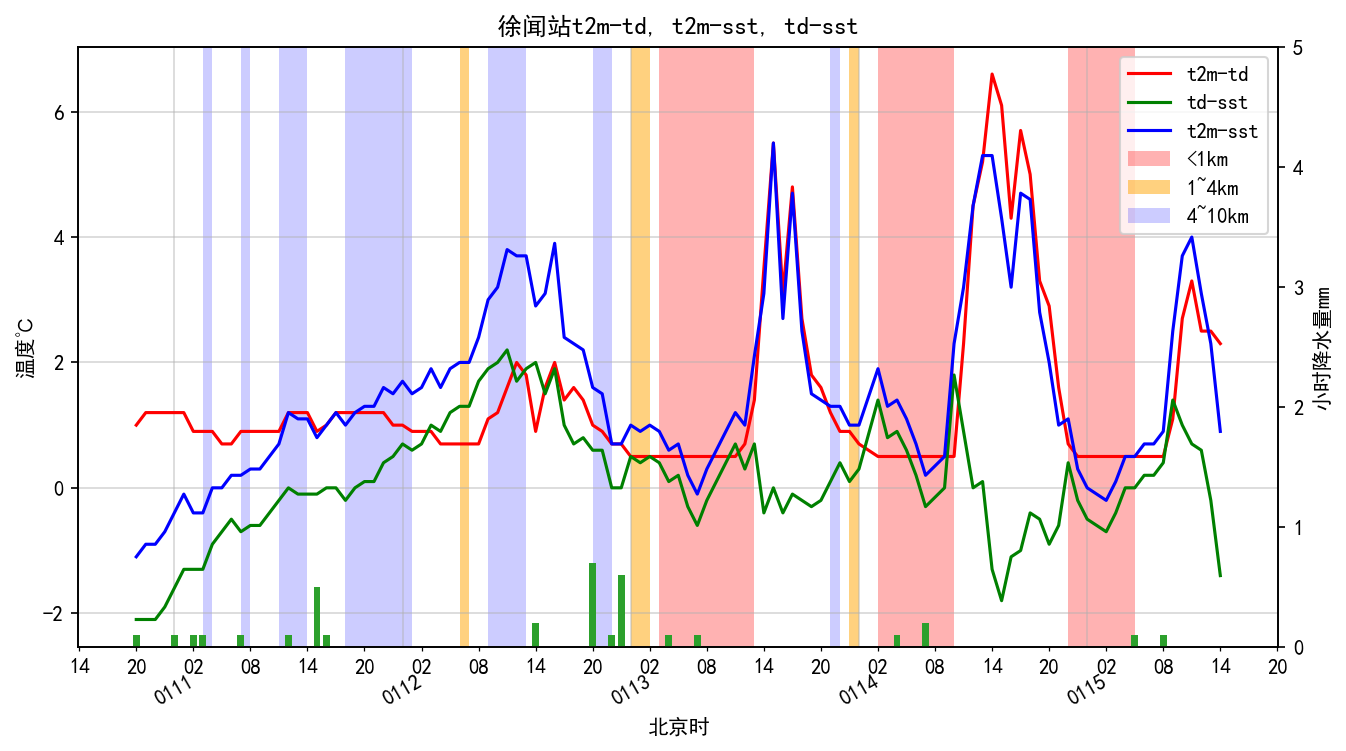

In [63]:
start_time = pd.Timestamp('2023-01-10 20:00')
end_time = pd.Timestamp('2023-01-15 14:00')
time_mask = ((df_59754_inter['ObserveTime'] >= start_time) & (df_59754_inter['ObserveTime'] <= end_time))
df_59754_mask = df_59754_inter.loc[time_mask]
df_G7425_mask = df_G7425_inter.loc[((df_G7425_inter['ObserveTime'] >= start_time) & (df_G7425_inter['ObserveTime'] <= end_time))]

fig = plt.figure(figsize=(8, 4), dpi=150)  # 添加画布
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylabel("海雾")
line_t2m, = ax.plot(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']]-df_59754_mask[code_info['td']], color='r', markersize=4, label='2m气温', zorder=2)
line_td, = ax.plot(df_59754_mask['ObserveTime'], df_59754_mask[code_info['td']].values-df_G7425_mask['SeaTemperature'].values, color='g',  label='露点', zorder=3)
line_sst, = ax.plot(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']].values-df_G7425_mask['SeaTemperature'].values, color='b', label='海温', zorder=4)
_,_x, ymin, ymax = plt.axis()
ax.set_ylim(ymin, ymax)
# bar_rain = ax2.bar(df_59754_mask['ObserveTime'], df_59754_mask[code_info['rain01']], linewidth=0, align='center', width=0.1, color='tab:green', label='降水', zorder=0)

# 绘制降水
ax2 = ax.twinx()
df_59754_time_int = df_59754_mask.loc[df_59754_mask['ObserveTime'].dt.minute==0]
bar_rain = ax2.bar(df_59754_time_int['ObserveTime'], df_59754_time_int[code_info['rain01']], linewidth=0, align='center', width=0.03, color='tab:green', label='降水', zorder=0)
ax2.set_ylim(0, 5)
ax2.set_ylabel("小时降水量mm")

# 绘制能见度区域
td_min = df_59754_mask[code_info['td']].min()
vis01 = ax.fill_between(df_59754_mask['ObserveTime'], ymax,ymin, where=df_59754_mask[code_info['vis01']] <= 1000, facecolor='red', alpha=.3)
vis02 = ax.fill_between(df_59754_mask['ObserveTime'], ymax,ymin, where=((df_59754_mask[code_info['vis01']] > 1000) & (df_59754_mask[code_info['vis_10min']]<=4000)), facecolor='orange', alpha=.5)
vis03 = ax.fill_between(df_59754_mask['ObserveTime'], ymax,ymin, where=((df_59754_mask[code_info['vis01']] > 4000) & (df_59754_mask[code_info['vis_10min']]<=10000)), facecolor='blue', alpha=.2)

# 设置x轴主刻度格式
alldays = mdates.DayLocator()  # 主刻度为每天
ax.xaxis.set_major_locator(alldays)  # 设置主刻度
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m%d'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
# 设置副刻度格式
hoursLoc = mpl.dates.HourLocator(byhour=[2, 8, 14, 20])  # 为6小时为1副刻度
ax.xaxis.set_minor_locator(hoursLoc)
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
# 参数pad用于设置刻度线与标签间的距离
ax.tick_params(axis='x', which='major', pad=12, length=0)
ax.grid(True,alpha=0.5)
ax.set_xlabel("北京时")
ax.set_ylabel("温度℃")
ax.set_title(f'徐闻站t2m-td, t2m-sst, td-sst')



plt.legend([line_t2m, line_td, line_sst,vis01,vis02,vis03], ['t2m-td', 'td-sst', 't2m-sst','<1km','1~4km','4~10km'])



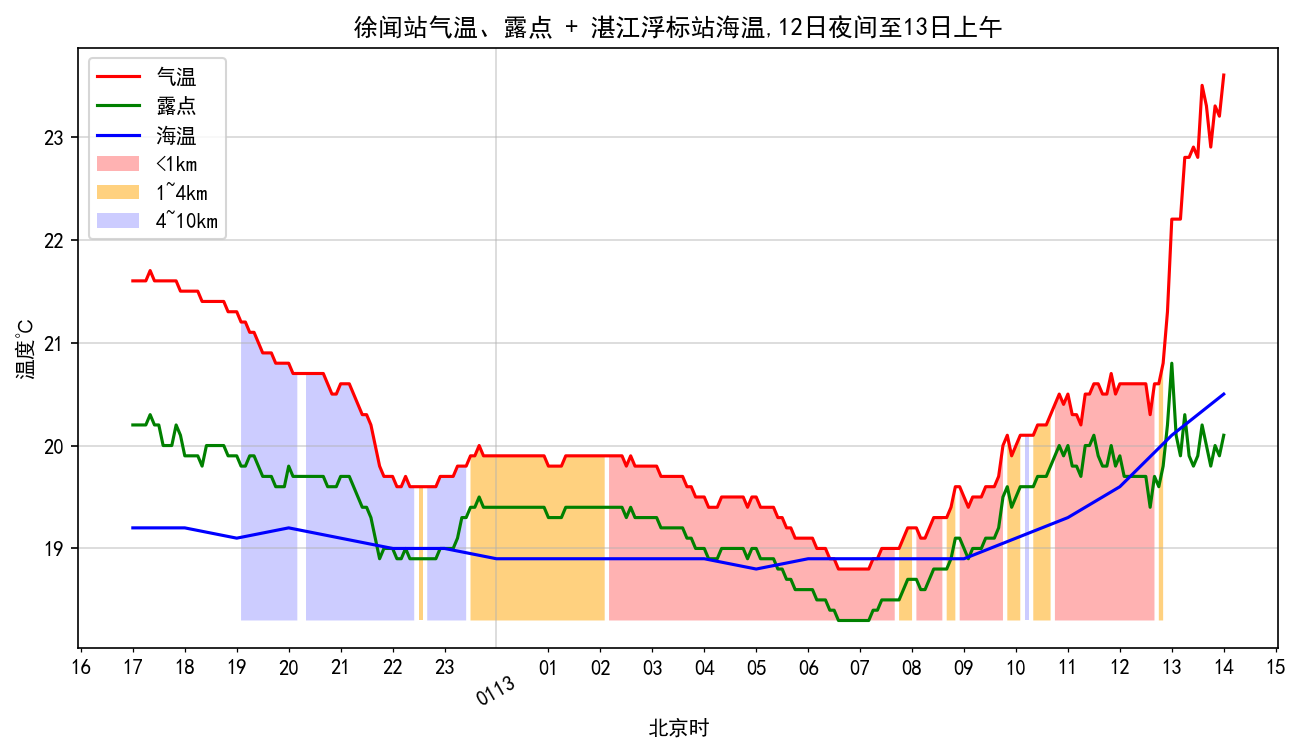

In [24]:
start_time = pd.Timestamp('2023-01-12 17:00')
end_time = pd.Timestamp('2023-01-13 14:00')
time_mask = ((df_59754['ObserveTime'] >= start_time) & (df_59754['ObserveTime'] <= end_time))
df_59754_mask = df_59754.loc[time_mask]
df_G7425_mask = df_G7425.loc[((df_G7425['ObserveTime'] >= start_time) & (df_G7425['ObserveTime'] <= end_time))]
fig = plt.figure(figsize=(8, 4), dpi=150)  # 添加画布
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylabel("海雾")
line_t2m, = ax.plot(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']], color='r', markersize=4, label='2m气温', zorder=2)
line_td, = ax.plot(df_59754_mask['ObserveTime'], df_59754_mask[code_info['td']], color='g',  label='露点', zorder=3)
line_sst, = ax.plot(df_G7425_mask.index, df_G7425_mask['SeaTemperature'], color='b', label='海温', zorder=4)

# 绘制能见度区域
td_min = df_59754_mask[code_info['td']].min()
vis01 = ax.fill_between(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']],td_min, where=df_59754_mask[code_info['vis_10min']] < 1000, facecolor='red', alpha=.3)
vis02 = ax.fill_between(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']],td_min, where=((df_59754_mask[code_info['vis_10min']] > 1000) & (df_59754_mask[code_info['vis_10min']]<4000)), facecolor='orange', alpha=.5)
vis03 = ax.fill_between(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']],td_min, where=((df_59754_mask[code_info['vis_10min']] > 4000) & (df_59754_mask[code_info['vis_10min']]<10000)), facecolor='blue', alpha=.2)

# 设置x轴主刻度格式
alldays = mdates.DayLocator()  # 主刻度为每天
ax.xaxis.set_major_locator(alldays)  # 设置主刻度
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m%d'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
# 设置副刻度格式
hoursLoc = mpl.dates.HourLocator(byhour=np.arange(0,24,1))  # 为6小时为1副刻度
ax.xaxis.set_minor_locator(hoursLoc)
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
# 参数pad用于设置刻度线与标签间的距离
ax.tick_params(axis='x', which='major', pad=12, length=0)
ax.grid(True,alpha=0.5)
ax.set_xlabel("北京时")
ax.set_ylabel("温度℃")
ax.set_title(f'徐闻站气温、露点 + 湛江浮标站海温,12日夜间至13日上午')



plt.legend([line_t2m, line_td, line_sst,vis01,vis02,vis03], ['气温', '露点', '海温','<1km','1~4km','4~10km'])



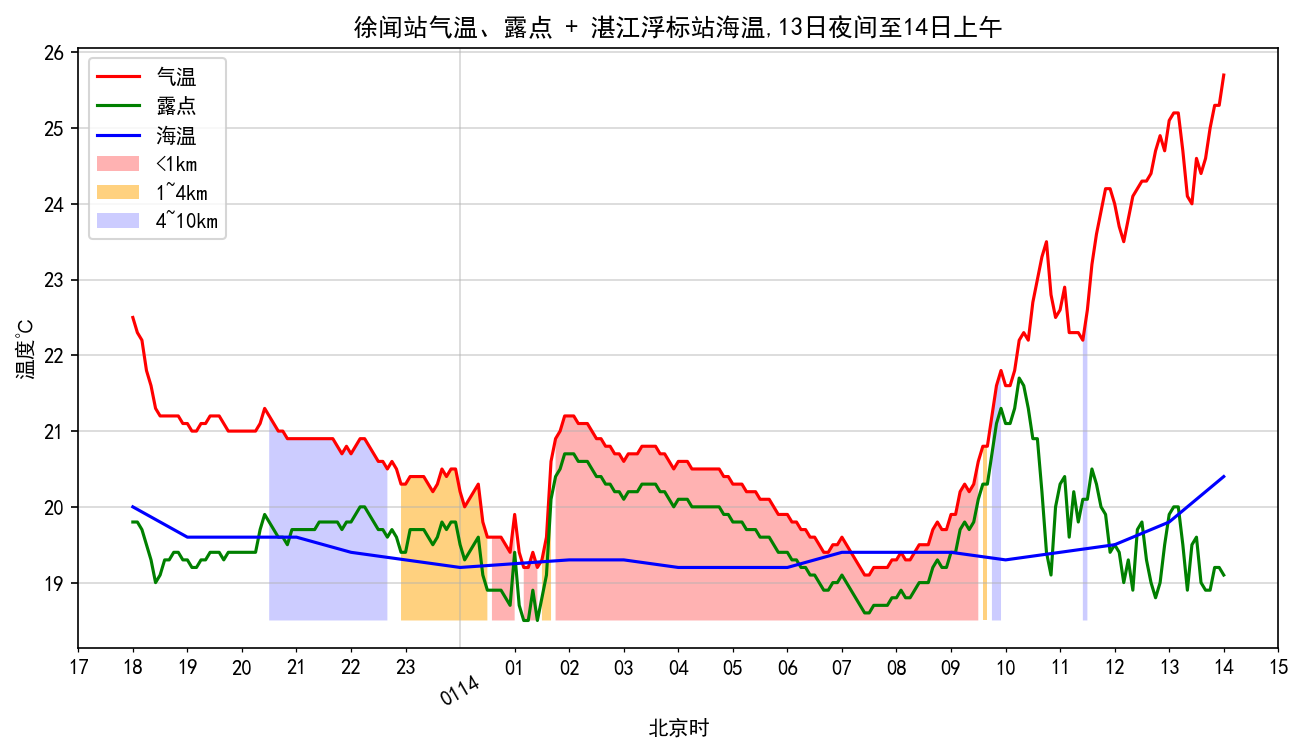

In [22]:
start_time = pd.Timestamp('2023-01-13 18:00')
end_time = pd.Timestamp('2023-01-14 14:00')
time_mask = ((df_59754['ObserveTime'] >= start_time) & (df_59754['ObserveTime'] <= end_time))
df_59754_mask = df_59754.loc[time_mask]
df_G7425_mask = df_G7425.loc[((df_G7425['ObserveTime'] >= start_time) & (df_G7425['ObserveTime'] <= end_time))]
fig = plt.figure(figsize=(8, 4), dpi=150)  # 添加画布
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylabel("海雾")
line_t2m, = ax.plot(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']], color='r', markersize=4, label='2m气温', zorder=2)
line_td, = ax.plot(df_59754_mask['ObserveTime'], df_59754_mask[code_info['td']], color='g',  label='露点', zorder=3)
line_sst, = ax.plot(df_G7425_mask.index, df_G7425_mask['SeaTemperature'], color='b', label='海温', zorder=4)

# 绘制能见度区域
td_min = df_59754_mask[code_info['td']].min()
vis01 = ax.fill_between(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']],td_min, where=df_59754_mask[code_info['vis_10min']] < 1000, facecolor='red', alpha=.3)
vis02 = ax.fill_between(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']],td_min, where=((df_59754_mask[code_info['vis_10min']] > 1000) & (df_59754_mask[code_info['vis_10min']]<4000)), facecolor='orange', alpha=.5)
vis03 = ax.fill_between(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']],td_min, where=((df_59754_mask[code_info['vis_10min']] > 4000) & (df_59754_mask[code_info['vis_10min']]<10000)), facecolor='blue', alpha=.2)

# 设置x轴主刻度格式
alldays = mdates.DayLocator()  # 主刻度为每天
ax.xaxis.set_major_locator(alldays)  # 设置主刻度
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m%d'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
# 设置副刻度格式
hoursLoc = mpl.dates.HourLocator(byhour=np.arange(0,24,1))  # 为6小时为1副刻度
ax.xaxis.set_minor_locator(hoursLoc)
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
# 参数pad用于设置刻度线与标签间的距离
ax.tick_params(axis='x', which='major', pad=12, length=0)
ax.grid(True,alpha=0.5)
ax.set_xlabel("北京时")
ax.set_ylabel("温度℃")
ax.set_title(f'徐闻站气温、露点 + 湛江浮标站海温,13日夜间至14日上午')

plt.legend([line_t2m, line_td, line_sst,vis01,vis02,vis03], ['气温', '露点', '海温','<1km','1~4km','4~10km'])

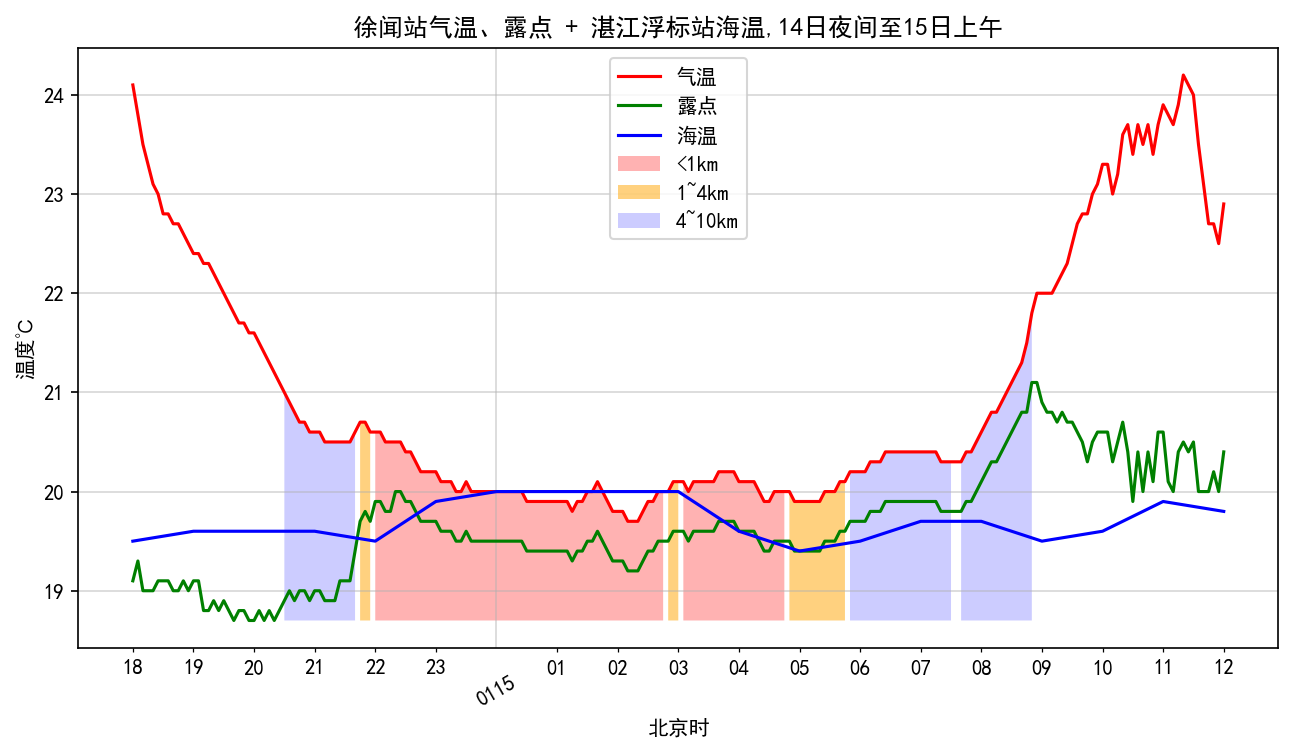

In [26]:
start_time = pd.Timestamp('2023-01-14 18:00')
end_time = pd.Timestamp('2023-01-15 12:00')
time_mask = ((df_59754['ObserveTime'] >= start_time) & (df_59754['ObserveTime'] <= end_time))
df_59754_mask = df_59754.loc[time_mask]
df_G7425_mask = df_G7425.loc[((df_G7425['ObserveTime'] >= start_time) & (df_G7425['ObserveTime'] <= end_time))]
fig = plt.figure(figsize=(8, 4), dpi=150)  # 添加画布
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylabel("海雾")
line_t2m, = ax.plot(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']], color='r', markersize=4, label='2m气温', zorder=2)
line_td, = ax.plot(df_59754_mask['ObserveTime'], df_59754_mask[code_info['td']], color='g',  label='露点', zorder=3)
line_sst, = ax.plot(df_G7425_mask.index, df_G7425_mask['SeaTemperature'], color='b', label='海温', zorder=4)

# 绘制能见度区域
td_min = df_59754_mask[code_info['td']].min()
vis01 = ax.fill_between(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']],td_min, where=df_59754_mask[code_info['vis_10min']] < 1000, facecolor='red', alpha=.3)
vis02 = ax.fill_between(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']],td_min, where=((df_59754_mask[code_info['vis_10min']] > 1000) & (df_59754_mask[code_info['vis_10min']]<4000)), facecolor='orange', alpha=.5)
vis03 = ax.fill_between(df_59754_mask['ObserveTime'], df_59754_mask[code_info['t2m']],td_min, where=((df_59754_mask[code_info['vis_10min']] > 4000) & (df_59754_mask[code_info['vis_10min']]<10000)), facecolor='blue', alpha=.2)

# 设置x轴主刻度格式
alldays = mdates.DayLocator()  # 主刻度为每天
ax.xaxis.set_major_locator(alldays)  # 设置主刻度
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m%d'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
# 设置副刻度格式
hoursLoc = mpl.dates.HourLocator(byhour=np.arange(0,24,1))  # 为6小时为1副刻度
ax.xaxis.set_minor_locator(hoursLoc)
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
# 参数pad用于设置刻度线与标签间的距离
ax.tick_params(axis='x', which='major', pad=12, length=0)
ax.grid(True,alpha=0.5)
ax.set_xlabel("北京时")
ax.set_ylabel("温度℃")
ax.set_title(f'徐闻站气温、露点 + 湛江浮标站海温,14日夜间至15日上午')

plt.legend([line_t2m, line_td, line_sst,vis01,vis02,vis03], ['气温', '露点', '海温','<1km','1~4km','4~10km'])